In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 各パス指定

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# 分類数設定

In [3]:
NUM_CLASSES = 10

# 学習データ読み込み

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,074 (8.10 KB)

 Trainable params: 2,074 (8.10 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [11]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 1/30 ━━━━━━━━━━━━━━━━━━━━ 27s 964ms/step - accuracy: 0.0859 - loss: 2.4280
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1291 - loss: 2.3076 - val_accuracy: 0.1734 - val_loss: 2.2061
Epoch 2/1000
 1/30 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.1641 - loss: 2.2159
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1883 - loss: 2.1963 - val_accuracy: 0.2855 - val_loss: 2.0930
Epoch 3/1000
 1/30 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2344 - loss: 2.1240
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2454 - loss: 2.1033 - val_accuracy: 0.4024 - val_loss: 1.9592
Epoch 4/1000
 1/30 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2188 - loss: 2.0700
Epoch 4: saving model to model/keypoint_classifier/keypoint_classifier.ker

In [12]:
# モデル評価
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9710 - loss: 0.1070 


In [13]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [14]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
[1.3079311e-06 8.5584462e-01 1.2435675e-01 1.8885307e-03 1.1464566e-05
 2.2497957e-06 1.6717084e-06 1.4647214e-02 2.5980554e-03 6.4814888e-04]
1


# 混同行列

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step


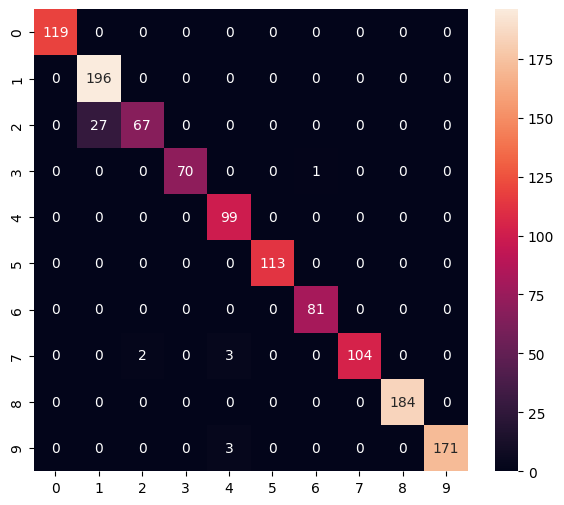

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       119
           1       0.88      1.00      0.94       196
           2       0.97      0.71      0.82        94
           3       1.00      0.99      0.99        71
           4       0.94      1.00      0.97        99
           5       1.00      1.00      1.00       113
           6       0.99      1.00      0.99        81
           7       1.00      0.95      0.98       109
           8       1.00      1.00      1.00       184
           9       1.00      0.98      0.99       174

    accuracy                           0.97      1240
   macro avg       0.98      0.96      0.97      1240
weighted avg       0.97      0.97      0.97      1240



In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [16]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)

In [17]:
# モデルを変換(量子化)
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\Ashraf\AppData\Local\Temp\tmpbhxde406\assets


INFO:tensorflow:Assets written to: C:\Users\Ashraf\AppData\Local\Temp\tmpbhxde406\assets


Saved artifact at 'C:\Users\Ashraf\AppData\Local\Temp\tmpbhxde406'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  1336178857184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1336173426496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1336227025968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1336227036704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1336208416032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1336208413920: TensorSpec(shape=(), dtype=tf.resource, name=None)


6840

# 推論テスト

In [18]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

c:\Users\Ashraf\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [19]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [20]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [21]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [ ]:
print(np.squeeze(tflite_results)) # type: ignore
print(np.argmax(np.squeeze(tflite_results))) # type: ignore

[9.9812064e-07 8.6250764e-01 1.1890065e-01 1.5642463e-03 1.0002272e-05
 1.7696069e-06 1.1878711e-06 1.4115907e-02 2.2838162e-03 6.1375590e-04]
1
